In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Reproducing same results
SEED = 2023

import random
import numpy as np

# Torch
import torch
device = torch.device("cuda" if torch.cuda.is_available() else"cpu" )


def seed_everything(seed = 2023):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [3]:
# Read train dataset
class ReadDataset(torch.utils.data.Dataset):
    def __init__(self, filename, target ,transform = None):
        with open(filename, 'r', encoding='iso-8859-1') as f:
            self.sentences = f.readlines()
            self.labels = []
            for sentence in self.sentences:
                label, text = sentence.strip().split(" ", 1)
                coarse = label.split(':')[0]
                if target == 'coarse':
                  self.labels.append(coarse)
                elif target == 'fine':
                  self.labels.append(label)
        self.transform = transform
    
    def __getitem__(self, index):
        # Get the sentence and label at the given index
        sentence = self.sentences[index].strip().split(' ', 1)[1]
        sentence = sentence.strip().lower().split()
              
        return sentence, self.labels[index]
        
    def __len__(self):
        return len(self.sentences)

In [4]:
# Read Coarse dataset
coarse_train_dataset = ReadDataset("/content/drive/MyDrive/Text Mining/train_5500.label", target = "coarse")

# Print the first 3 samples
for i in range(3):
  sample = coarse_train_dataset[i]
  print((i, sample))

(0, (['how', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'russia', '?'], 'DESC'))
(1, (['what', 'films', 'featured', 'the', 'character', 'popeye', 'doyle', '?'], 'ENTY'))
(2, (['how', 'can', 'i', 'find', 'a', 'list', 'of', 'celebrities', "'", 'real', 'names', '?'], 'DESC'))


In [5]:
# Read fine dataset
fine_train_dataset = ReadDataset("/content/drive/MyDrive/Text Mining/train_5500.label", target = "fine")

# Print the first 3 samples
for i in range(3):
  sample = fine_train_dataset[i]
  print((i, sample))

(0, (['how', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'russia', '?'], 'DESC:manner'))
(1, (['what', 'films', 'featured', 'the', 'character', 'popeye', 'doyle', '?'], 'ENTY:cremat'))
(2, (['how', 'can', 'i', 'find', 'a', 'list', 'of', 'celebrities', "'", 'real', 'names', '?'], 'DESC:manner'))


Using torchetext

In [6]:
# # Create vocab
# from torchtext.vocab import build_vocab_from_iterator

# # Define a function that yields the tokenized sentences/labels in the dataset
# def sentence_iterator(dataset):
#     for sentence, _ in dataset:
#         yield sentence

# # Build a vocabulary from the tokenized sentences
# train_vocab = build_vocab_from_iterator(sentence_iterator(coarse_train_dataset), specials=['<unk>'])
# train_vocab.set_default_index(train_vocab["<unk>"])

# # Print the size of the vocabulary
# print(f"Vocabulary size: {len(train_vocab)}")

In [7]:
train_vocab = {}
for sentence, _ in coarse_train_dataset:
  for w in sentence:
    if w not in train_vocab:
      train_vocab[w] = len(train_vocab)

train_vocab['<unk>'] = len(train_vocab)

In [8]:
# Example of indices
[train_vocab[token] for token in ['here', 'is', 'an', 'example']]

[1516, 34, 115, 2786]

In [9]:
# Load test Coarse dataet
coarse_test_dataset = ReadDataset("/content/drive/MyDrive/Text Mining/TREC_10.label", target = "coarse")

# Print the first 3 samples
for i in range(3):
  sample = coarse_test_dataset[i]
  print((i, sample))

(0, (['how', 'far', 'is', 'it', 'from', 'denver', 'to', 'aspen', '?'], 'NUM'))
(1, (['what', 'county', 'is', 'modesto', ',', 'california', 'in', '?'], 'LOC'))
(2, (['who', 'was', 'galileo', '?'], 'HUM'))


In [10]:
# Load test Fine dataet
fine_test_dataset = ReadDataset("/content/drive/MyDrive/Text Mining/TREC_10.label", target = "fine")

# Print the first 3 samples
for i in range(3):
  sample = fine_test_dataset[i]
  print((i, sample))

(0, (['how', 'far', 'is', 'it', 'from', 'denver', 'to', 'aspen', '?'], 'NUM:dist'))
(1, (['what', 'county', 'is', 'modesto', ',', 'california', 'in', '?'], 'LOC:city'))
(2, (['who', 'was', 'galileo', '?'], 'HUM:desc'))


In [11]:
print(len(coarse_test_dataset))
print(len(fine_test_dataset))

500
500


In [12]:
def text_pipeline(sentence):
  indexed_sentence = []
  for w in sentence:
    if w in train_vocab:
      indexed_sentence.append(train_vocab[w])
    else:
      indexed_sentence.append(train_vocab['<unk>'])
  return indexed_sentence

In [13]:
def coarse_label_pipeline(label):
  if label == "ABBR":
    return 0
  elif label == "DESC":
    return 1
  elif label == "ENTY":
    return 2
  elif label == "HUM":
    return 3
  elif label == "LOC":
    return 4
  elif label == "NUM":
    return 5

In [14]:
def fine_label_pipeline(label):
  if label == "ABBR:abb":
    return 0
  elif label == "ABBR:exp":
    return 1
  elif label == "ENTY:animal":
    return 2
  elif label == "ENTY:body":
    return 3
  elif label == "ENTY:color":
    return 4
  elif label == "ENTY:cremat":
    return 5
  elif label == "ENTY:currency":
    return 6
  elif label == "ENTY:dismed":
    return 7
  elif label == "ENTY:event":
    return 8
  elif label == "ENTY:food":
    return 9
  elif label == "ENTY:instru":
    return 10
  elif label == "ENTY:lang":
    return 11
  elif label == "ENTY:letter":
    return 12
  elif label == "ENTY:other":
    return 13
  elif label == "ENTY:plant":
    return 14
  elif label == "ENTY:product":
    return 15
  elif label == "ENTY:religion":
    return 16
  elif label == "ENTY:sport":
    return 17
  elif label == "ENTY:substance":
    return 18
  elif label == "ENTY:symbol":
    return 19
  elif label == "ENTY:techmeth":
    return 20
  elif label == "ENTY:termeq":
    return 21
  elif label == "ENTY:veh":
    return 22
  elif label == "ENTY:word":
    return 23
  elif label == "DESC:def":
    return 24
  elif label == "DESC:desc":
    return 25
  elif label == "DESC:manner":
    return 26
  elif label == "DESC:reason":
    return 27
  elif label == "HUM:gr":
    return 28
  elif label == "HUM:ind":
    return 29
  elif label == "HUM:title":
    return 30
  elif label == "HUM:desc":
    return 31
  elif label == "LOC:city":
    return 32
  elif label == "LOC:country":
    return 33
  elif label == "LOC:mount":
    return 34
  elif label == "LOC:other":
    return 35
  elif label == "LOC:state":
    return 36
  elif label == "NUM:code":
    return 37
  elif label == "NUM:count":
    return 38
  elif label == "NUM:date":
    return 39
  elif label == "NUM:dist":
    return 40
  elif label == "NUM:money":
    return 41
  elif label == "NUM:ord":
    return 42
  elif label == "NUM:other":
    return 43
  elif label == "NUM:period":
    return 44
  elif label == "NUM:perc":
    return 45
  elif label == "NUM:speed":
    return 46
  elif label == "NUM:temp":
    return 47
  elif label == "NUM:volsize":
    return 48
  elif label == "NUM:weight":
    return 49 

In [15]:
# Example of usage of coarse pipelines
print(text_pipeline(coarse_train_dataset[0][0]))
print(coarse_label_pipeline(coarse_train_dataset[0][1]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
1


In [16]:
# Example of usage of fine pipelines
print(text_pipeline(fine_train_dataset[0][0]))
print(fine_label_pipeline(fine_train_dataset[0][1]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
26


In [17]:
# Collate without padding for BoW: Coarse dataloader
from torch.utils.data import DataLoader
def collate_batch_coarse(batch):
  label_list, text_list, offsets = [], [], [0]
  for (_text, _label) in batch:
      label_list.append(coarse_label_pipeline(_label))
      processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
      text_list.append(processed_text)
      offsets.append(processed_text.size(0))
  label_list = torch.tensor(label_list, dtype=torch.int64)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  text_list = torch.cat(text_list)
  return text_list, offsets, label_list

In [18]:
# Collate without padding for BoW: Fine dataloader
from torch.utils.data import DataLoader
def collate_batch_fine(batch):
  label_list, text_list, offsets = [], [], [0]
  for (_text, _label) in batch:
      label_list.append(fine_label_pipeline(_label))
      processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
      text_list.append(processed_text)
      offsets.append(processed_text.size(0))
  label_list = torch.tensor(label_list, dtype=torch.int64)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  text_list = torch.cat(text_list)
  return text_list, offsets, label_list

In [19]:
# Collate with padding for BiLSTM: Coarse dataloader
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

'''def collate_batch_padding(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_text, _label) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    return text_list, offsets, label_list'''


def collate_batch_padding2_coarse(batch):
  # Let's assume that each element in "batch" is a tuple (data, label).
  # Sort the batch in the descending order
  sorted_batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)

  label_list, text_list, offsets = [], [], [0]
  for (_text, _label) in sorted_batch:
      label_list.append(coarse_label_pipeline(_label))
      processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
      text_list.append(processed_text)
      offsets.append(processed_text.size(0))
  label_list = torch.tensor(label_list, dtype=torch.int64)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

  # Get each sequence and pad it
  sequences = [x for x in text_list]
  sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
  # Also need to store the length of each sequence
  # This is later needed in order to unpad the sequences
  lengths = torch.LongTensor([len(x) for x in sequences])
  
  return sequences_padded, lengths, label_list

In [20]:
# Collate with padding for BiLSTM: Fine dataloader
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

'''def collate_batch_padding(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_text, _label) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    return text_list, offsets, label_list'''


def collate_batch_padding2_fine(batch):
  # Let's assume that each element in "batch" is a tuple (data, label).
  # Sort the batch in the descending order
  sorted_batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)

  label_list, text_list, offsets = [], [], [0]
  for (_text, _label) in sorted_batch:
      label_list.append(fine_label_pipeline(_label))
      processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
      text_list.append(processed_text)
      offsets.append(processed_text.size(0))
  label_list = torch.tensor(label_list, dtype=torch.int64)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

  # Get each sequence and pad it
  sequences = [x for x in text_list]
  sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
  # Also need to store the length of each sequence
  # This is later needed in order to unpad the sequences
  lengths = torch.LongTensor([len(x) for x in sequences])
  
  return sequences_padded, lengths, label_list

In [21]:
# Load Glove
## Create a dic of glove {word:vector}

import numpy as np

glove_file = '/content/drive/MyDrive/Text Mining/glove.small.txt'
glove_dict = {}

with open(glove_file, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_dict[word] = coefs

print(len(glove_dict))

glove_embed_size = np.stack(glove_dict.values()).shape[1]
print(glove_embed_size)

9549
300


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [22]:
# # Create a weight matrix using glove_dict & vocab of train dataset

#matrix_len = len(train_vocab)
# glove_weights_matrix = np.zeros((matrix_len, glove_embed_size))
# words_found = 0

# for i, word in enumerate(train_vocab.get_itos()):
#   try: 
#     glove_weights_matrix[i] = glove_dict[word]
#     words_found += 1
#   except KeyError:
#     glove_weights_matrix[i] = np.random.normal(scale=0.6, size=(glove_embed_size, ))
# print(words_found)
# print(glove_weights_matrix.shape)

In [23]:
matrix_len = len(train_vocab)

glove_weights_matrix = np.zeros((matrix_len, glove_embed_size))
words_found = 0

for i, word in enumerate(train_vocab):
  try: 
    glove_weights_matrix[i] = glove_dict[word]
    words_found += 1
  except KeyError:
    glove_weights_matrix[i] = np.random.normal(scale=0.6, size=(glove_embed_size, ))
print(words_found)
print(glove_weights_matrix.shape)

5764
(8679, 300)


## Define Model class

In [24]:
# Bag of Words

import torch.nn as nn
import torch.nn.functional as F
class QuestionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, use_glove, fine_tune_embed):
        super().__init__()
        self.use_glove = use_glove
        self.fine_tune_embed = fine_tune_embed

        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True) # Bag-of-Words
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        # random initialised embedding
        if self.use_glove == False:
          self.embedding.weight.data.uniform_(-initrange, initrange) 
        # Glove embedding
        else:
          self.embedding.weight = nn.Parameter(torch.tensor(glove_weights_matrix, dtype=torch.float32))
        
        # If freeze the embedding weight
        if self.fine_tune_embed == False: 
          self.embedding.requires_grad_(False)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()


    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        x = self.fc(embedded)
        return x

In [25]:
# BiLSTM
from torch.nn.utils.rnn import pad_sequence

class BiLSTM3(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, num_class, use_glove, fine_tune_embed):
        super(BiLSTM3, self).__init__()
        self.use_glove = use_glove
        self.fine_tune_embed = fine_tune_embed

        self.hidden_size = 64
        drp = 0.3
        # n_classes = len(le.classes_)
        self.embedding = nn.Embedding(vocab_size, embed_dim, sparse=False)
        self.lstm = nn.LSTM(embed_dim, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear1 = nn.Linear(self.hidden_size*4 , 60)
        self.linear2 = nn.Linear(60, 30)  # new linear layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(30, num_class)  # changed output size to match new layer
        self.softmax = nn.Softmax(dim=1)  # new softmax layer
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        # random initialised embedding
        if self.use_glove == False:
          self.embedding.weight.data.uniform_(-initrange, initrange) 
        # Glove embedding
        else:
          self.embedding.weight = nn.Parameter(torch.tensor(glove_weights_matrix, dtype=torch.float32))
        
        # If freeze the embedding weight
        if self.fine_tune_embed == False: 
          self.embedding.weight.requires_grad_(False)

    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear1(conc))
        conc = self.relu(self.linear2(conc))  # apply second linear layer and activation
        conc = self.dropout(conc)
        out = self.out(conc)
        out = self.softmax(out)  # apply softmax layer
        return out

## Train, Val, Test class

In [26]:
from torch.utils.data import DataLoader
import time
from torch.utils.data.dataset import random_split

import matplotlib.pyplot as plt

class TrainValTestModel():
  def __init__(self, model, collate_fn, n_epochs, batch_size, min_valid_loss) -> None:
     self.model = model
     self.collate_fn = collate_fn
     self.n_epochs = n_epochs
     self.batch_size = batch_size
     self.min_valid_loss = min_valid_loss

     # CrossEntropyLoss already contains Softmax function inside
     self.criterion = torch.nn.CrossEntropyLoss().to(device)
     self.optimizer = torch.optim.SGD(self.model.parameters(), lr=4.0)
     self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)

  def split_into_train_valid(self, train_dataset, train_ratio = 0.90):
    train_len = int(len(train_dataset) * train_ratio)
    sub_train_, sub_valid_ = random_split(train_dataset, [train_len, len(train_dataset) - train_len],generator=torch.Generator().manual_seed(42))
    return sub_train_, sub_valid_

  def train(self, sub_train):
    # Set the model to train mode
    self.model.train()
    # Train model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train, batch_size=self.batch_size, shuffle=True,
                      collate_fn=self.collate_fn)
    for i, (text, offsets, cls) in enumerate(data):
        self.optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        # print(f'text: {text}')
        # print(f'offsets: {offsets}')
        # print(f'cls: {cls}')
        output = self.model(text, offsets)
        # print(f'output: {output}')
        loss = self.criterion(output, cls)
        # print(f'loss: {loss}')
        train_loss += loss.item()
        loss.backward()
        self.optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
    # Update learning rate
    self.scheduler.step()

    return train_loss / len(sub_train), train_acc / len(sub_train)

  def validate(self, sub_valid):
    self.model.eval()
    loss = 0
    acc = 0
    valid_preds = []
    valid_labels = []
    data = DataLoader(sub_valid, batch_size=self.batch_size, collate_fn=self.collate_fn)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = self.model(text, offsets)
            loss += self.criterion(output, cls).item()
            acc += (output.argmax(1) == cls).sum().item()
            valid_preds += output.argmax(1).tolist()
            valid_labels += cls.tolist()

    return loss / len(sub_valid), acc / len(sub_valid), valid_preds, valid_labels

  def f1_score_macro(self, y_true, y_pred):
    num_labels = len(np.unique(y_true))
    f1_scores = []
    for label in range(num_labels):
        tp = np.sum(np.logical_and(y_pred == label, y_true == label))
        fp = np.sum(np.logical_and(y_pred == label, y_true != label))
        fn = np.sum(np.logical_and(y_pred != label, y_true == label))
        eps = 1e-7  # epsilon to avoid division by zero
        precision = tp / (tp + fp + eps)
        recall = tp / (tp + fn + eps)
        f1 = 2 * precision * recall / (precision + recall + eps)
        f1_scores.append(f1)
    macro_f1_score = np.mean(f1_scores)
    return macro_f1_score
  

  def train_and_evaluate(self, train_dataset, train_ratio=0.90):
    sub_train, sub_valid = self.split_into_train_valid(train_dataset, train_ratio=train_ratio)
    print('[Train & Validation]')

    train_loss_list = []
    valid_loss_list = []
    valid_preds_list = []
    valid_labels_list = []
    for epoch in range(self.n_epochs):
        start_time = time.time()
        train_loss, train_acc = self.train(sub_train)
        valid_loss, valid_acc, valid_preds, valid_labels = self.validate(sub_valid)

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        self.train_loss_list = train_loss_list
        self.valid_loss_list = valid_loss_list
        valid_preds_list.append(valid_preds)
        valid_labels_list.append(valid_labels)

        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60

        print('Epoch: %d' % (epoch + 1), " | time in %d minutes, %d seconds" % (mins, secs))
        print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

    # Calculate macro F1 score
    valid_preds_all = np.concatenate(valid_preds_list)
    valid_labels_all = np.concatenate(valid_labels_list)
    macro_f1_score = self.f1_score_macro(valid_labels_all, valid_preds_all)
    print('Macro F1 score: %.4f' % macro_f1_score)
  
  def loss_plot(self):
    fig = plt.figure(figsize=(6, 6))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(self.n_epochs)+1), self.train_loss_list, label='train')
    plt.plot(list(np.arange(self.n_epochs)+1), self.valid_loss_list, label='valid')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

  def test(self, test_dataset):
    test_loss, test_acc, test_preds, test_labels = self.validate(test_dataset)
    print('[Test]')
    print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

In [27]:
# for BiLSTM ver2
from torch.utils.data import DataLoader
import time
from torch.utils.data.dataset import random_split

import matplotlib.pyplot as plt

class TrainValTestBiLSTMModel():
  def __init__(self, model, collate_fn, n_epochs, batch_size, min_valid_loss) -> None:
     self.model = model
     self.collate_fn = collate_fn
     self.n_epochs = n_epochs
     self.batch_size = batch_size
     self.min_valid_loss = min_valid_loss

     # CrossEntropyLoss already contains Softmax function inside
     self.criterion = torch.nn.CrossEntropyLoss().to(device)
     self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-2)
     self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)

  def split_into_train_valid(self, train_dataset, train_ratio = 0.90):
    train_len = int(len(train_dataset) * train_ratio)
    sub_train_, sub_valid_ = random_split(train_dataset, [train_len, len(train_dataset) - train_len])
    return sub_train_, sub_valid_

  def train(self, sub_train):
    print("train func starts")
    # Set the model to train mode
    self.model.train()
    # Train model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train, batch_size=self.batch_size, shuffle=True,
                      collate_fn=self.collate_fn)
    print("loop starts")
    for i, (text, offsets, cls) in enumerate(data):
        self.optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        #print(f'text: {text}')
        #print(f'offsets: {offsets}')
        #print(f'cls: {cls}')
        output = self.model(text)
        #print(f'output: {output}')
        loss = self.criterion(output, cls)
        #print(f'loss: {loss}')
        train_loss += loss.item()
        loss.backward()
        self.optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
    # Update learning rate
    self.scheduler.step()

    return train_loss / len(sub_train), train_acc / len(sub_train)


  def validate(self, sub_valid):
    self.model.eval()
    loss = 0
    acc = 0
    valid_preds2 = []
    valid_labels2 = []
    data = DataLoader(sub_valid, batch_size=self.batch_size, collate_fn=self.collate_fn)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = self.model(text)
            loss = self.criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
            valid_preds2 += output.argmax(1).tolist()
            valid_labels2 += cls.tolist()

    return loss / len(sub_valid), acc / len(sub_valid), valid_preds2, valid_labels2

  def f1_score_macro(self, y_true, y_pred):
    num_labels = len(np.unique(y_true))
    f1_scores = []
    for label in range(num_labels):
        tp = np.sum(np.logical_and(y_pred == label, y_true == label))
        fp = np.sum(np.logical_and(y_pred == label, y_true != label))
        fn = np.sum(np.logical_and(y_pred != label, y_true == label))
        eps = 1e-7  # epsilon to avoid division by zero
        precision = tp / (tp + fp + eps)
        recall = tp / (tp + fn + eps)
        f1 = 2 * precision * recall / (precision + recall + eps)
        f1_scores.append(f1)
    macro_f1_score = np.mean(f1_scores)
    return macro_f1_score    

  def train_and_evaluate(self, train_dataset, train_ratio=0.90):
    sub_train, sub_valid = self.split_into_train_valid(train_dataset, train_ratio=train_ratio)
    train_loss_list = []
    valid_loss_list = []
    valid_preds_list = []
    valid_labels_list = []
    for epoch in range(self.n_epochs):
        start_time = time.time()
        train_loss, train_acc = self.train(sub_train)
        valid_loss, valid_acc, valid_preds2, valid_labels2 = self.validate(sub_valid)

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        self.train_loss_list = train_loss_list
        self.valid_loss_list = valid_loss_list
        valid_preds_list.append(valid_preds2)
        valid_labels_list.append(valid_labels2)

        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60

        print('Epoch: %d' % (epoch + 1), " | time in %d minutes, %d seconds" % (mins, secs))
        print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

    # Calculate macro F1 score
    valid_preds_all = np.concatenate(valid_preds_list)
    valid_labels_all = np.concatenate(valid_labels_list)
    macro_f1_score = self.f1_score_macro(valid_labels_all, valid_preds_all)
    print('Macro F1 score: %.4f' % macro_f1_score)
  
  def loss_plot(self):
    fig = plt.figure(figsize=(6, 6))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(self.n_epochs)+1), self.train_loss_list, label='train')
    plt.plot(list(np.arange(self.n_epochs)+1), self.valid_loss_list, label='valid')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

  def test(self, test_dataset):
    test_loss, test_acc, test_preds, test_labels = self.validate(test_dataset)
    print('[Test]')
    print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

In [28]:
# Coarse Model

VOCAB_SIZE = len(train_vocab)
EMBED_DIM = glove_embed_size # 300
NUM_CLASS_coarse = len(set(coarse_train_dataset.labels))
print(f'num class: {NUM_CLASS_coarse}')

num class: 6


In [29]:
# Fine Model

VOCAB_SIZE = len(train_vocab)
EMBED_DIM = glove_embed_size # 300
NUM_CLASS_fine = len(set(fine_train_dataset.labels))
print(f'num class: {NUM_CLASS_fine}')

num class: 50


In [30]:
# lr = 1e-4
dropout_prob = 0.5
# max_document_length = 100  # each sentence has until 100 words
# max_size = 5000 # maximum vocabulary size
num_hidden_nodes = 93
hidden_dim2 = 128
num_layers = 2  # LSTM layers
bi_directional = True 

## Coarse Classification

Bag of Words: Random+FineTune

name :  embedding.weight
name :  fc.weight
name :  fc.bias
[Train & Validation]
Epoch: 1  | time in 0 minutes, 1 seconds
	Loss: 0.0625(train)	|	Acc: 63.5%(train)
	Loss: 0.0751(valid)	|	Acc: 59.3%(valid)
Epoch: 2  | time in 0 minutes, 2 seconds
	Loss: 0.0305(train)	|	Acc: 82.3%(train)
	Loss: 0.0532(valid)	|	Acc: 74.5%(valid)
Epoch: 3  | time in 0 minutes, 2 seconds
	Loss: 0.0184(train)	|	Acc: 89.5%(train)
	Loss: 0.0456(valid)	|	Acc: 78.2%(valid)
Epoch: 4  | time in 0 minutes, 2 seconds
	Loss: 0.0099(train)	|	Acc: 94.9%(train)
	Loss: 0.0517(valid)	|	Acc: 79.3%(valid)
Epoch: 5  | time in 0 minutes, 1 seconds
	Loss: 0.0051(train)	|	Acc: 98.2%(train)
	Loss: 0.0448(valid)	|	Acc: 81.7%(valid)
Epoch: 6  | time in 0 minutes, 0 seconds
	Loss: 0.0032(train)	|	Acc: 99.0%(train)
	Loss: 0.0476(valid)	|	Acc: 82.1%(valid)
Epoch: 7  | time in 0 minutes, 0 seconds
	Loss: 0.0019(train)	|	Acc: 99.8%(train)
	Loss: 0.0482(valid)	|	Acc: 81.0%(valid)
Epoch: 8  | time in 0 minutes, 0 seconds
	Loss: 0.0014(trai

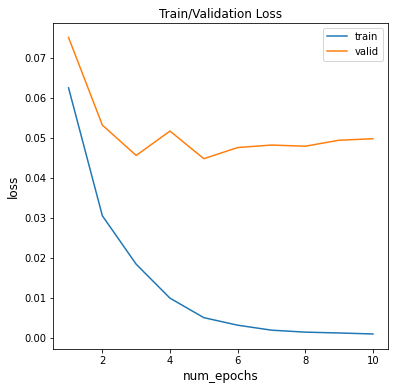

In [31]:
model1 = QuestionClassifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS_coarse, use_glove=False, fine_tune_embed=True).to(device)

# Print weights and biases in each layer
for name, param in model1.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model1_evaluator = TrainValTestModel(model = model1, collate_fn = collate_batch_coarse, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model1_evaluator.train_and_evaluate(train_dataset=coarse_train_dataset)
model1_evaluator.test(test_dataset=coarse_test_dataset)
model1_evaluator.loss_plot()

Bag of Words: Glove+Freeze

name :  embedding.weight
name :  fc.weight
name :  fc.bias
[Train & Validation]
Epoch: 1  | time in 0 minutes, 0 seconds
	Loss: 0.2965(train)	|	Acc: 45.4%(train)
	Loss: 0.2323(valid)	|	Acc: 54.6%(valid)
Epoch: 2  | time in 0 minutes, 0 seconds
	Loss: 0.1366(train)	|	Acc: 60.9%(train)
	Loss: 0.1479(valid)	|	Acc: 55.5%(valid)
Epoch: 3  | time in 0 minutes, 0 seconds
	Loss: 0.1056(train)	|	Acc: 64.3%(train)
	Loss: 0.5573(valid)	|	Acc: 36.8%(valid)
Epoch: 4  | time in 0 minutes, 0 seconds
	Loss: 0.0918(train)	|	Acc: 66.5%(train)
	Loss: 0.1135(valid)	|	Acc: 61.9%(valid)
Epoch: 5  | time in 0 minutes, 0 seconds
	Loss: 0.0765(train)	|	Acc: 69.1%(train)
	Loss: 0.1078(valid)	|	Acc: 60.1%(valid)
Epoch: 6  | time in 0 minutes, 0 seconds
	Loss: 0.0707(train)	|	Acc: 70.1%(train)
	Loss: 0.0837(valid)	|	Acc: 63.6%(valid)
Epoch: 7  | time in 0 minutes, 0 seconds
	Loss: 0.0628(train)	|	Acc: 72.0%(train)
	Loss: 0.0918(valid)	|	Acc: 63.2%(valid)
Epoch: 8  | time in 0 minutes, 0 seconds
	Loss: 0.0576(trai

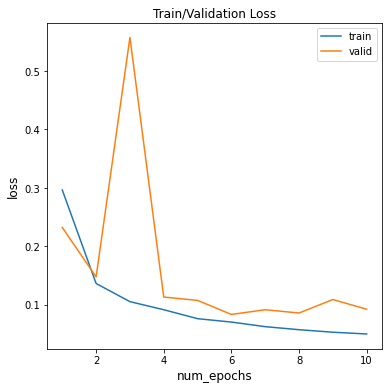

In [32]:
model2 = QuestionClassifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS_coarse, use_glove=True, fine_tune_embed=False).to(device)

# Print weights and biases in each layer
for name, param in model2.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model2_evaluator = TrainValTestModel(model = model2, collate_fn = collate_batch_coarse, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model2_evaluator.train_and_evaluate(train_dataset=coarse_train_dataset)
model2_evaluator.test(test_dataset=coarse_test_dataset)
model2_evaluator.loss_plot()

Bag of Words: Glove+FineTune

name :  embedding.weight
name :  fc.weight
name :  fc.bias
[Train & Validation]
Epoch: 1  | time in 0 minutes, 1 seconds
	Loss: 0.0645(train)	|	Acc: 68.2%(train)
	Loss: 0.0483(valid)	|	Acc: 75.5%(valid)
Epoch: 2  | time in 0 minutes, 1 seconds
	Loss: 0.0263(train)	|	Acc: 85.0%(train)
	Loss: 0.0584(valid)	|	Acc: 72.2%(valid)
Epoch: 3  | time in 0 minutes, 1 seconds
	Loss: 0.0152(train)	|	Acc: 91.8%(train)
	Loss: 0.0473(valid)	|	Acc: 80.2%(valid)
Epoch: 4  | time in 0 minutes, 0 seconds
	Loss: 0.0077(train)	|	Acc: 96.0%(train)
	Loss: 0.0456(valid)	|	Acc: 80.8%(valid)
Epoch: 5  | time in 0 minutes, 0 seconds
	Loss: 0.0040(train)	|	Acc: 98.7%(train)
	Loss: 0.0508(valid)	|	Acc: 79.7%(valid)
Epoch: 6  | time in 0 minutes, 0 seconds
	Loss: 0.0024(train)	|	Acc: 99.6%(train)
	Loss: 0.0465(valid)	|	Acc: 81.9%(valid)
Epoch: 7  | time in 0 minutes, 0 seconds
	Loss: 0.0015(train)	|	Acc: 99.9%(train)
	Loss: 0.0474(valid)	|	Acc: 80.8%(valid)
Epoch: 8  | time in 0 minutes, 0 seconds
	Loss: 0.0012(trai

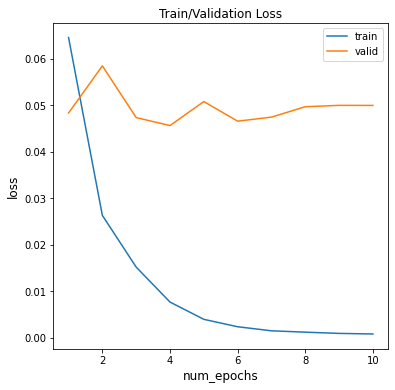

In [33]:
model3 = QuestionClassifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS_coarse, use_glove=True, fine_tune_embed=True).to(device)

# Print weights and biases in each layer
for name, param in model2.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model3_evaluator = TrainValTestModel(model = model3, collate_fn = collate_batch_coarse, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model3_evaluator.train_and_evaluate(train_dataset=coarse_train_dataset)
model3_evaluator.test(test_dataset=coarse_test_dataset)
model3_evaluator.loss_plot()

BiLSTM: Random+FineTune

name :  embedding.weight
name :  lstm.weight_ih_l0
name :  lstm.weight_hh_l0
name :  lstm.bias_ih_l0
name :  lstm.bias_hh_l0
name :  lstm.weight_ih_l0_reverse
name :  lstm.weight_hh_l0_reverse
name :  lstm.bias_ih_l0_reverse
name :  lstm.bias_hh_l0_reverse
name :  linear1.weight
name :  linear1.bias
name :  linear2.weight
name :  linear2.bias
name :  out.weight
name :  out.bias
train func starts
loop starts
Epoch: 1  | time in 0 minutes, 19 seconds
	Loss: 0.0991(train)	|	Acc: 44.4%(train)
	Loss: 0.0038(valid)	|	Acc: 57.3%(valid)
train func starts
loop starts
Epoch: 2  | time in 0 minutes, 20 seconds
	Loss: 0.0876(train)	|	Acc: 64.1%(train)
	Loss: 0.0038(valid)	|	Acc: 60.8%(valid)
train func starts
loop starts
Epoch: 3  | time in 0 minutes, 27 seconds
	Loss: 0.0822(train)	|	Acc: 72.8%(train)
	Loss: 0.0039(valid)	|	Acc: 71.6%(valid)
train func starts
loop starts
Epoch: 4  | time in 0 minutes, 25 seconds
	Loss: 0.0789(train)	|	Acc: 78.0%(train)
	Loss: 0.0057(valid)	|	Acc: 71.4%(valid)
tra

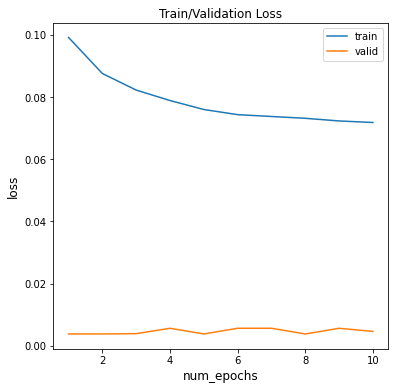

In [34]:
model4 = BiLSTM3(VOCAB_SIZE, EMBED_DIM, num_class=NUM_CLASS_coarse, use_glove=False, fine_tune_embed=True).to(device)

# Print weights and biases in each layer
for name, param in model4.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model4_evaluator = TrainValTestBiLSTMModel(model = model4, collate_fn = collate_batch_padding2_coarse, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model4_evaluator.train_and_evaluate(train_dataset=coarse_train_dataset)
model4_evaluator.test(test_dataset=coarse_test_dataset)
model4_evaluator.loss_plot()

BiLSTM: Glove+Freeze

name :  embedding.weight
name :  lstm.weight_ih_l0
name :  lstm.weight_hh_l0
name :  lstm.bias_ih_l0
name :  lstm.bias_hh_l0
name :  lstm.weight_ih_l0_reverse
name :  lstm.weight_hh_l0_reverse
name :  lstm.bias_ih_l0_reverse
name :  lstm.bias_hh_l0_reverse
name :  linear1.weight
name :  linear1.bias
name :  linear2.weight
name :  linear2.bias
name :  out.weight
name :  out.bias
train func starts
loop starts
Epoch: 1  | time in 0 minutes, 8 seconds
	Loss: 0.0957(train)	|	Acc: 49.6%(train)
	Loss: 0.0052(valid)	|	Acc: 72.0%(valid)
train func starts
loop starts
Epoch: 2  | time in 0 minutes, 12 seconds
	Loss: 0.0832(train)	|	Acc: 71.8%(train)
	Loss: 0.0038(valid)	|	Acc: 70.9%(valid)
train func starts
loop starts
Epoch: 3  | time in 0 minutes, 9 seconds
	Loss: 0.0793(train)	|	Acc: 77.6%(train)
	Loss: 0.0038(valid)	|	Acc: 78.8%(valid)
train func starts
loop starts
Epoch: 4  | time in 0 minutes, 10 seconds
	Loss: 0.0766(train)	|	Acc: 82.0%(train)
	Loss: 0.0038(valid)	|	Acc: 81.5%(valid)
train

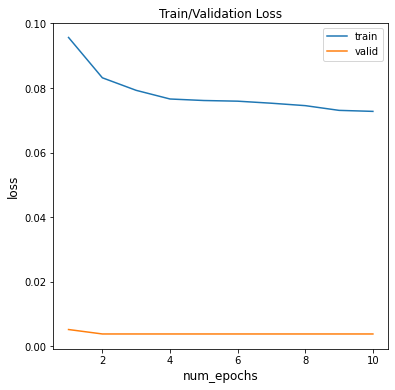

In [35]:
model5 = BiLSTM3(VOCAB_SIZE, EMBED_DIM, num_class=NUM_CLASS_coarse, use_glove=True, fine_tune_embed=False).to(device)

# Print weights and biases in each layer
for name, param in model5.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model5_evaluator = TrainValTestBiLSTMModel(model = model5, collate_fn = collate_batch_padding2_coarse, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model5_evaluator.train_and_evaluate(train_dataset=coarse_train_dataset)
model5_evaluator.test(test_dataset=coarse_test_dataset)
model5_evaluator.loss_plot()

BiLSTM: Glove+FineTune

In [ ]:
model6 = BiLSTM3(VOCAB_SIZE, EMBED_DIM, num_class=NUM_CLASS_coarse, use_glove=True, fine_tune_embed=True).to(device)

# Print weights and biases in each layer
for name, param in model6.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model6_evaluator = TrainValTestBiLSTMModel(model = model6, collate_fn = collate_batch_padding2_coarse, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model6_evaluator.train_and_evaluate(train_dataset=coarse_train_dataset)
model6_evaluator.test(test_dataset=coarse_test_dataset)
model6_evaluator.loss_plot()

name :  embedding.weight
name :  lstm.weight_ih_l0
name :  lstm.weight_hh_l0
name :  lstm.bias_ih_l0
name :  lstm.bias_hh_l0
name :  lstm.weight_ih_l0_reverse
name :  lstm.weight_hh_l0_reverse
name :  lstm.bias_ih_l0_reverse
name :  lstm.bias_hh_l0_reverse
name :  linear1.weight
name :  linear1.bias
name :  linear2.weight
name :  linear2.bias
name :  out.weight
name :  out.bias
train func starts
loop starts
Epoch: 1  | time in 0 minutes, 23 seconds
	Loss: 0.0952(train)	|	Acc: 50.7%(train)
	Loss: 0.0038(valid)	|	Acc: 73.4%(valid)
train func starts
loop starts
Epoch: 2  | time in 0 minutes, 29 seconds
	Loss: 0.0781(train)	|	Acc: 79.4%(train)
	Loss: 0.0057(valid)	|	Acc: 81.0%(valid)
train func starts
loop starts
Epoch: 3  | time in 0 minutes, 34 seconds
	Loss: 0.0756(train)	|	Acc: 83.5%(train)
	Loss: 0.0057(valid)	|	Acc: 80.0%(valid)
train func starts
loop starts
Epoch: 4  | time in 0 minutes, 41 seconds
	Loss: 0.0735(train)	|	Acc: 86.9%(train)
	Loss: 0.0057(valid)	|	Acc: 81.1%(valid)
tra

## Fine Classification

Bag of Words: Random+FineTune

In [ ]:
model7 = QuestionClassifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS_fine, use_glove=False, fine_tune_embed=True).to(device)

# Print weights and biases in each layer
for name, param in model7.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model7_evaluator = TrainValTestModel(model = model7, collate_fn = collate_batch_fine, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model7_evaluator.train_and_evaluate(train_dataset=fine_train_dataset)
model7_evaluator.test(test_dataset=fine_test_dataset)
model7_evaluator.loss_plot()

Bag of Words: Glove+Freeze

In [ ]:
model8 = QuestionClassifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS_fine, use_glove=True, fine_tune_embed=False).to(device)

# Print weights and biases in each layer
for name, param in model8.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model8_evaluator = TrainValTestModel(model = model8, collate_fn = collate_batch_fine, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model8_evaluator.train_and_evaluate(train_dataset=fine_train_dataset)
model8_evaluator.test(test_dataset=fine_test_dataset)
model8_evaluator.loss_plot()

Bag of Words: Glove+FineTune

In [ ]:
model9 = QuestionClassifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASS_fine, use_glove=True, fine_tune_embed=True).to(device)

# Print weights and biases in each layer
for name, param in model9.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model9_evaluator = TrainValTestModel(model = model9, collate_fn = collate_batch_fine, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model9_evaluator.train_and_evaluate(train_dataset=fine_train_dataset)
model9_evaluator.test(test_dataset=fine_test_dataset)
model9_evaluator.loss_plot()

BiLSTM: Random+FineTune

In [ ]:
model10 = BiLSTM3(VOCAB_SIZE, EMBED_DIM, num_class=NUM_CLASS_fine, use_glove=False, fine_tune_embed=True).to(device)

# Print weights and biases in each layer
for name, param in model10.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model10_evaluator = TrainValTestBiLSTMModel(model = model10, collate_fn = collate_batch_padding2_fine, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model10_evaluator.train_and_evaluate(train_dataset=fine_train_dataset)
model10_evaluator.test(test_dataset=fine_test_dataset)
model10_evaluator.loss_plot()

BiLSTM: Glove+Freeze

In [ ]:
model11 = BiLSTM3(VOCAB_SIZE, EMBED_DIM, num_class=NUM_CLASS_fine, use_glove=True, fine_tune_embed=False).to(device)

# Print weights and biases in each layer
for name, param in model11.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model11_evaluator = TrainValTestBiLSTMModel(model = model11, collate_fn = collate_batch_padding2_fine, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model11_evaluator.train_and_evaluate(train_dataset=fine_train_dataset)
model11_evaluator.test(test_dataset=fine_test_dataset)
model11_evaluator.loss_plot()

BiLSTM: Glove+FineTune

In [ ]:
model12 = BiLSTM3(VOCAB_SIZE, EMBED_DIM, num_class=NUM_CLASS_fine, use_glove=True, fine_tune_embed=True).to(device)

# Print weights and biases in each layer
for name, param in model12.named_parameters():
  print('name : ', name)
  # print('param : ', param)

model12_evaluator = TrainValTestBiLSTMModel(model = model12, collate_fn = collate_batch_padding2_fine, n_epochs=10, batch_size=16, min_valid_loss=float('inf'))
model12_evaluator.train_and_evaluate(train_dataset=fine_train_dataset)
model12_evaluator.test(test_dataset=fine_test_dataset)
model12_evaluator.loss_plot()